# Imports

In [1]:
import random

from qqdm.notebook import qqdm as qqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

import torch
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset)
from torch.optim import Adam

# Model

In [2]:
class WeirdTrafficNet(nn.Module):
	def __init__(self, in_dim):
		super(WeirdTrafficNet, self).__init__()

		#encoder_layer_dims = [in_dim, 31, 15, 6] #@30 epochs: train sep 7.7, 2/14 FTP 1.212, 2/14 SSH 0.461
		#encoder_layer_dims = [in_dim, 45, 25, 6] #@30 epochs: train sep 14.5, 2/14 FTP 1.437, 2/14 SSH 0.234
		#encoder_layer_dims = [in_dim, 45, 35, 6] #@30 epochs: train sep 11.2, 2/14 FTP 1.03, 2/14 SSH 0.49
		#encoder_layer_dims = [in_dim, 50, 35, 6] #@30 epochs: train sep 10.7, 2/14 FTP 0.529, 2/14 SSH 0.156
		encoder_layer_dims = [in_dim, 50, 35, 5] #@30 epochs: train sep 19.2, 2/14 FTP 2.04, 2/14 SSH 0.0006
		relu_inplace = True

		self.encoder = nn.Sequential(
			nn.Linear(encoder_layer_dims[0], encoder_layer_dims[1]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[1], encoder_layer_dims[2]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[2], encoder_layer_dims[3]),
			nn.ReLU(relu_inplace),
		)

		self.decoder = nn.Sequential(
			nn.Linear(encoder_layer_dims[3], encoder_layer_dims[2]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[2], encoder_layer_dims[1]),
			nn.ReLU(relu_inplace),
			nn.Linear(encoder_layer_dims[1], encoder_layer_dims[0]),
			nn.Sigmoid()
			#nn.Tanh()
			#nn.ReLU()
		)

	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x

# Load Data
- Can concat all data into one dataframe

In [3]:
#Run with all files for testing on the entire set
# data1 = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.csv')
# data2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.csv')
# data3 = pd.read_csv('Friday-WorkingHours-Morning.csv')
# data4 = pd.read_csv('Monday-WorkingHours.csv')
# data5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.csv')
# data6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.csv')
# data7 = pd.read_csv('Tuesday-WorkingHours.csv')
# data8 = pd.read_csv('Wednesday-workingHours.csv')

# data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8])
# del data1, data2, data3, data4, data5, data6, data7, data8

#Run on just one day for testing
data = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.csv')

# Make Columns Equivalent to CIC-IDS-2018

In [4]:
print('columns:',list(data.columns))

columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' 

In [5]:
cols_2018_to_2017 = {
	'Flow Duration'     : ' Flow Duration',
	'Tot Fwd Pkts'      : ' Total Fwd Packets',
	'Tot Bwd Pkts'      : ' Total Backward Packets',
	'TotLen Fwd Pkts'   : 'Total Length of Fwd Packets',
	'TotLen Bwd Pkts'   : ' Total Length of Bwd Packets',
	'Fwd Pkt Len Max'   : ' Fwd Packet Length Max',
	'Fwd Pkt Len Min'   : ' Fwd Packet Length Min',
	'Fwd Pkt Len Mean'  : ' Fwd Packet Length Mean',
	'Fwd Pkt Len Std'   : ' Fwd Packet Length Std',
	'Bwd Pkt Len Max'   : 'Bwd Packet Length Max',
	'Bwd Pkt Len Min'   : ' Bwd Packet Length Min',
	'Bwd Pkt Len Mean'  : ' Bwd Packet Length Mean',
	'Bwd Pkt Len Std'   : ' Bwd Packet Length Std',
	'Flow Byts/s'       : 'Flow Bytes/s',
	'Flow Pkts/s'       : ' Flow Packets/s',
	'Flow IAT Mean'     : ' Flow IAT Mean',
	'Flow IAT Std'      : ' Flow IAT Std',
	'Flow IAT Max'      : ' Flow IAT Max',
	'Flow IAT Min'      : ' Flow IAT Min',
	'Fwd IAT Tot'       : 'Fwd IAT Total',
	'Fwd IAT Mean'      : ' Fwd IAT Mean',
	'Fwd IAT Std'       : ' Fwd IAT Std',
	'Fwd IAT Max'       : ' Fwd IAT Max',
	'Fwd IAT Min'       : ' Fwd IAT Min',
	'Bwd IAT Tot'       : 'Bwd IAT Total',
	'Bwd IAT Mean'      : ' Bwd IAT Mean',
	'Bwd IAT Std'       : ' Bwd IAT Std',
	'Bwd IAT Max'       : ' Bwd IAT Max',
	'Bwd IAT Min'       : ' Bwd IAT Min',
	'Fwd Header Len'    : ' Fwd Header Length',
	'Bwd Header Len'    : ' Bwd Header Length',
	'Fwd Pkts/s'        : 'Fwd Packets/s',
	'Bwd Pkts/s'        : ' Bwd Packets/s',
	'Pkt Len Min'       : ' Min Packet Length',
	'Pkt Len Max'       : ' Max Packet Length',
	'Pkt Len Mean'      : ' Packet Length Mean',
	'Pkt Len Std'       : ' Packet Length Std',
	'Pkt Len Var'       : ' Packet Length Variance',
	'FIN Flag Cnt'      : 'FIN Flag Count',
	'SYN Flag Cnt'      : ' SYN Flag Count',
	'RST Flag Cnt'      : ' RST Flag Count',
	'PSH Flag Cnt'      : ' PSH Flag Count',
	'URG Flag Cnt'      : ' URG Flag Count',
	'ECE Flag Cnt'      : ' ECE Flag Count',
	'Down/Up Ratio'     : ' Down/Up Ratio',
	'Pkt Size Avg'      : ' Average Packet Size',
	'Fwd Seg Size Avg'  : ' Avg Fwd Segment Size',
	'Bwd Seg Size Avg'  : ' Avg Bwd Segment Size',
	'Subflow Fwd Pkts'  : 'Subflow Fwd Packets',
	'Subflow Fwd Byts'  : ' Subflow Fwd Bytes',
	'Subflow Bwd Pkts'  : ' Subflow Bwd Packets',
	'Subflow Bwd Byts'  : ' Subflow Bwd Bytes',
	'Init Fwd Win Byts' : 'Init_Win_bytes_forward',
	'Init Bwd Win Byts' : ' Init_Win_bytes_backward',
	'Fwd Act Data Pkts' : ' act_data_pkt_fwd',
	'Fwd Seg Size Min'  : ' min_seg_size_forward',
	'Active Mean'       : 'Active Mean',
	'Active Std'        : ' Active Std',
	'Active Min'        : ' Active Min',
	'Idle Mean'         : 'Idle Mean',
	'Idle Std'          : ' Idle Std',
	'Idle Max'          : ' Idle Max',
	'Idle Min'          : ' Idle Min',
	'Label'             : ' Label'
}

cols_2017_to_2018 = {}
for key in cols_2018_to_2017:
	cols_2017_to_2018[cols_2018_to_2017[key]] = key

final_order = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']

In [6]:
#Remove columns not used
for col in data.columns:
	if col not in cols_2017_to_2018:
		print('Removing', col, 'column')
		data = data.drop([col], axis=1)

#Replace column names with CIC-IDS-2018 names
new_cols = []
for i in range(len(data.columns)):
	new_cols.append(cols_2017_to_2018[data.columns[i]])
data.columns = new_cols

#Check that order of columns is the same
good_order = True
for i in range(len(new_cols)):
	if new_cols[i] != final_order[i]:
		print('Column', i+1, 'is', new_cols[i], 'instead of', final_order[i])
		good_order = False
if good_order:
	print('Order of columns is good!')

del new_cols, good_order
del col, i, key



Removing  Destination Port column
Removing Fwd PSH Flags column
Removing  Bwd PSH Flags column
Removing  Fwd URG Flags column
Removing  Bwd URG Flags column
Removing  ACK Flag Count column
Removing  CWE Flag Count column
Removing  Fwd Header Length.1 column
Removing Fwd Avg Bytes/Bulk column
Removing  Fwd Avg Packets/Bulk column
Removing  Fwd Avg Bulk Rate column
Removing  Bwd Avg Bytes/Bulk column
Removing  Bwd Avg Packets/Bulk column
Removing Bwd Avg Bulk Rate column
Removing  Active Max column
Order of columns is good!


In [7]:
print(data.columns)

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts

In [8]:
def IQR_normalization(dataframe: pd.DataFrame, normalizaiton: dict = None):
	norm_dict = {}
	if normalizaiton == None:
		for cat in dataframe.columns:
			#dict[category] = [max, 75percentile, mean, 25percentile, min]
			norm_dict[cat] = [0, 0, 0, 0, 0]
			norm_dict[cat][0] = dataframe[cat].max()
			norm_dict[cat][1] = dataframe[cat].quantile(0.75)
			norm_dict[cat][2] = dataframe[cat].mean()
			norm_dict[cat][3] = dataframe[cat].quantile(0.25)
			norm_dict[cat][4] = dataframe[cat].min()
	else:
		norm_dict = normalizaiton
	
	for cat in norm_dict:
		if norm_dict[cat][1] - norm_dict[cat][4] != 0:
			dataframe[cat] = (dataframe[cat] - norm_dict[cat][4]) / ( norm_dict[cat][1] - norm_dict[cat][4] )
		else:
			print(f'scaling col {cat} differently...')
			dataframe[cat].where(dataframe[cat] <= 1.0, 1.0, inplace=True)

	
	dataframe.where(dataframe <= 1.0, 1.0, inplace=True)

	if normalizaiton == None:
		return norm_dict

In [9]:
def clean_dataframe(data: pd.DataFrame, normalization = None):
	print('label counts:')
	print(data['Label'].value_counts())

	#Remove entries with null values
	data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

	#Remove label from dataframe prior to standardization
	labels = data['Label'].values
	data = data.drop(['Label'], axis=1)

	#Change everything to float64
	for col in data.columns:
		data[col] = pd.to_numeric(data[col])

	#Remove nan again
	nan_mask = data.isin([np.nan, np.inf, -np.inf]).any(1)
	labels = labels[~nan_mask]
	data = data[~nan_mask]

	IQR_normalization(data, normalization)

	#Check for nulls
	null_counts = data.isin([np.nan, np.inf, -np.inf]).sum()
	for i in range(len(null_counts)):
		if null_counts[i] != 0:
			assert False,f'{data.columns[i]} has null values after standardization'

	return data.values, labels

In [10]:
with open('normalization.data','rb') as f:
	normalization = pickle.load(f)

del f

In [11]:
data, labels = clean_dataframe(data, normalization)

label counts:
DDoS      128027
BENIGN     97718
Name: Label, dtype: int64
scaling col FIN Flag Cnt differently...
scaling col SYN Flag Cnt differently...
scaling col RST Flag Cnt differently...
scaling col URG Flag Cnt differently...
scaling col ECE Flag Cnt differently...
scaling col Active Mean differently...
scaling col Active Std differently...
scaling col Active Min differently...
scaling col Idle Mean differently...
scaling col Idle Std differently...
scaling col Idle Max differently...
scaling col Idle Min differently...


In [12]:
data_copy = data

In [13]:
data = data_copy

# Get ready to calculate losses

In [14]:
unique_labels, counts = np.unique(labels, return_counts=True)
losses = {}

for idx in range(len(unique_labels)):
	losses[unique_labels[idx]] = list(range(counts[idx]))

In [16]:
model = torch.load('2018_model.pth')
model.eval()

criterion = nn.MSELoss()

In [17]:
losses = {}

gpu_data = torch.from_numpy(data).float()
gpu_data = gpu_data.cuda()

for idx in qqdm(range(gpu_data.size(0))):
	if labels[idx] not in losses:
		losses[labels[idx]] = []

	output = model(gpu_data[idx])
	loss = criterion(output, gpu_data[idx])
	losses[labels[idx]].append(loss.item())
	

     Iters        Elapsed Time        Speed                                     
 225711/225711  00:01:28<00:00:00  2558.81it/s                                  

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [18]:
#Save data bc that took a long time
with open('processed_results.data','wb') as f:
	pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)

In [19]:
#Plot losses
loss = []
loss_label = []
for label in losses:
	loss.append(losses[label])
	loss_label.append(label)

(0.0, 0.15)

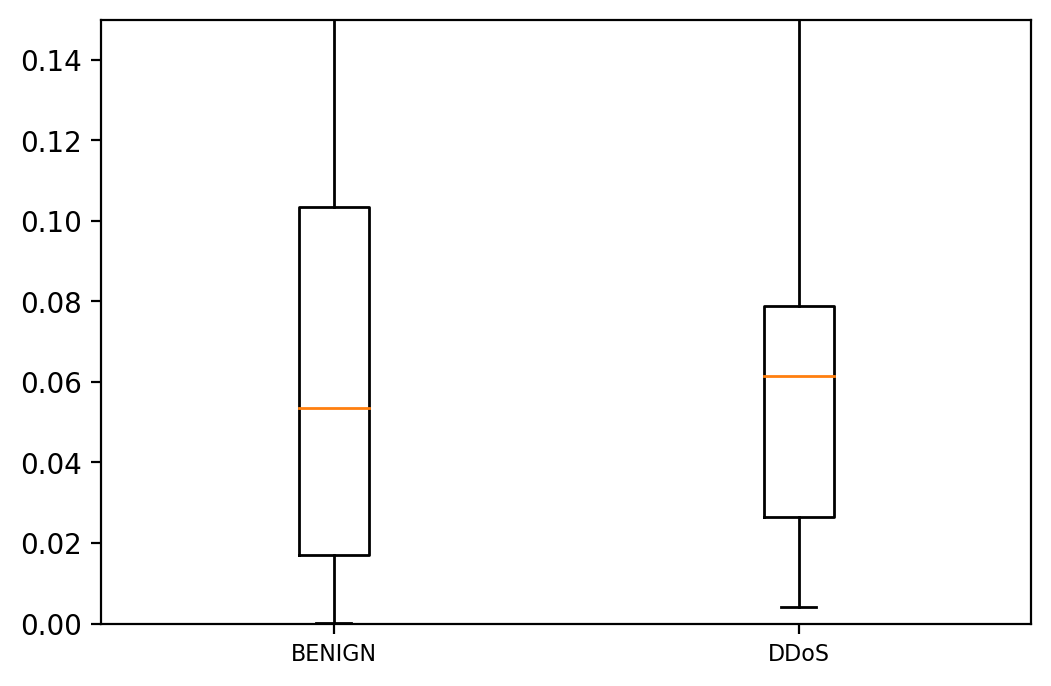

In [25]:
#Following line if run over entire dataset
# fig = plt.figure(dpi=250, figsize=(18,3))
#Following line for a single day
fig = plt.figure(dpi=200)
plt.boxplot(loss)
plt.xticks(list(range(1,len(losses)+1)), loss_label, fontsize=8)
plt.ylim(0,0.15)

In [21]:
def separation_index(base_losses: list, target_losses: list):
	return (-1*np.median(base_losses) + np.median(target_losses)) / ( np.percentile(base_losses, 95) - np.percentile(base_losses, 5) )

In [22]:
for label in losses:
	if label == 'BENIGN':
		continue
	print(label, 'seperation = \t', separation_index(losses['BENIGN'], losses[label]))


DDoS seperation = 	 0.04908632434814565
